# Caching

Interacting with files on a cloud provider can mean a lot of waiting on files downloading and uploading. `cloudpathlib` provides seamless on-demand caching of cloud content that can be persistent across processes and sessions to make sure you only download or upload when you need to.

## Are we synced?

Before `cloudpathlib`, we spent a lot of time syncing our remote and local files. There was no great solution. For example, I just need one file, but I only have a script that downloads the entire 800GB bucket (or worse, you can't remember exactly _which_ files you need 🤮). Or _even worse_, you have all the files synced to your local machine, but you suspect that some are are up-to-date and some are stale. More often that I'd like to admit, the simplest answer was to blast the whole data directory and download all over again. Bandwidth doesn't grow on trees!


## Cache me if you can

Part of what makes `cloudpathlib` so useful is that it takes care of all of that, leaving your precious mental resources free to do other things! It maintains a local cache and only downloads a file if the local version and remote versions are out of sync. Every time you read or write a file, `cloudpathlib` goes through these steps:

- Does the file exist in the cache already?
- If no, download it to the cache.
- If yes, does the cached version have the same modified time as the cloud version?
- If it is older, re-download the file and replace the old cached version with the updated version from the cloud.
- If the local one is newer, something is up! We don't want to overwrite your local changes with the version from the cloud. If we see this scenario, we'll raise an error and offer some options to resolve the versions.

## Supporting reading and writing

The cache logic also support writing to cloud files seamlessly in addition to reading. We do this by tracking when a `CloudPath` is opened and on the close of that file, we will upload the new version to the cloud if it has changed.

**Warning** we don't upload files that weren't opened for write by `cloudpathlib`. For example, if you edit a file in the cache manually in a text edior, `cloudpathlib` won't know to update that file on the cloud. If you want to write to a file in the cloud, you should use the `open` or `write` methods, for example:

```python
with my_cloud_path.open("w") as f:
    f.write("My new text!")
```

This will download the file, write the text to the local version in the cache, and when that file is closed we know to upload the changed version to the cloud.

As an example, let's look at using the [Low Altitude Disaster Imagery](https://registry.opendata.aws/ladi/) open dataset on S3. We'll view one images available of a flooding incident available on S3.

In [1]:
from cloudpathlib import CloudPath
from itertools import islice

ladi = CloudPath("s3://ladi/Images/FEMA_CAP/2020/70349")

# list first 5 images for this incident
for p in islice(ladi.iterdir(), 5):
    print(p)

s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0001_5a63d42e-27c6-448a-84f1-bfc632125b8e.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0003_02c30af6-911e-4e01-8c24-7644da2b8672.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0004_d37c02b9-01a8-4672-b06f-2690d70e5e6b.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0005_d05609ce-1c45-4de3-b0f1-401c2bb3412c.jpg


Just because we saw these images are available, it doesn't mean we have downloaded any of this data yet.

In [2]:
# Nothing in the cache yet
!tree {ladi.fspath}

/var/folders/8g/v8lwvfhj6_l6ct_zd_rs84mw0000gn/T/tmpn5oh1rkm/ladi/Images/FEMA_CAP/2020/70349 [error opening dir]

0 directories, 0 files


Now let's look at just the first image from this dataset, confirming that the file exists on S3.

In [3]:
flood_image = ladi / "DSC_0001_5a63d42e-27c6-448a-84f1-bfc632125b8e.jpg"
flood_image.exists()

True

In [4]:
# Still nothing in the cache
!tree {ladi.fspath}

/var/folders/8g/v8lwvfhj6_l6ct_zd_rs84mw0000gn/T/tmpn5oh1rkm/ladi/Images/FEMA_CAP/2020/70349 [error opening dir]

0 directories, 0 files


Even though we refer to a specific file and make sure it exists in the cloud, we can still do all of that work without actually downloading the file.

In order to read the file, we do have to download the data. Let's actually display the image:

CPU times: user 1.35 s, sys: 435 ms, total: 1.78 s
Wall time: 1.76 s


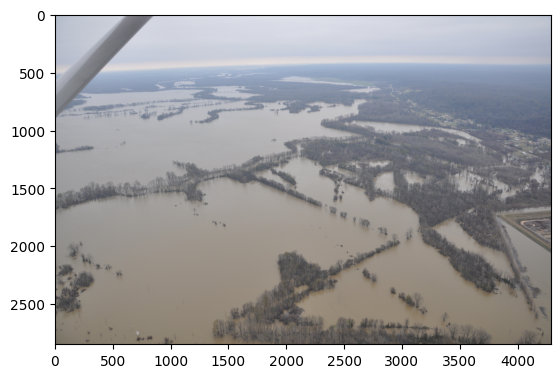

In [5]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

with flood_image.open("rb") as f:
    i = Image.open(f)
    plt.imshow(i)

In [6]:
# Downloaded image file in the cache
!tree {ladi.fspath}

/var/folders/8g/v8lwvfhj6_l6ct_zd_rs84mw0000gn/T/tmpn5oh1rkm/ladi/Images/FEMA_CAP/2020/70349
└── DSC_0001_5a63d42e-27c6-448a-84f1-bfc632125b8e.jpg

0 directories, 1 file


Just by using `open`, we've downloaded the file in the background to the cache. Now that it is local, we won't redownload that file unless it changes on the server. We can confirm that by checking if the file is faster to read a second time.

CPU times: user 233 ms, sys: 69.7 ms, total: 303 ms
Wall time: 491 ms


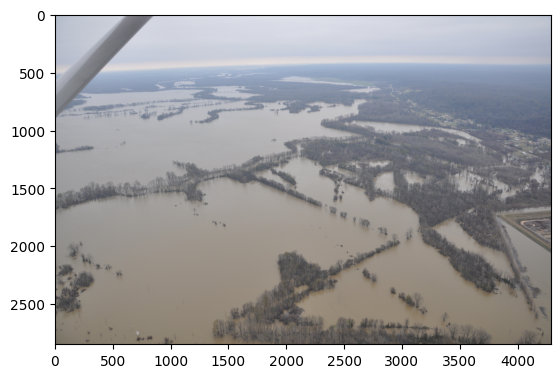

In [7]:
%%time
with flood_image.open("rb") as f:
    i = Image.open(f)
    plt.imshow(i)

Notice that the second display is much faster since we use the cached version!

## Keeping the cache around

By default, the cache uses [`tempfile`](https://docs.python.org/3/library/tempfile.html) this means at some point either Python or your operating system will remove whatever files you have cached. This is helpful in that it means the downloaded files get cleaned up regularly and don't necessarily clutter up your local hard drive. If you want more control over how and when the cache is removed, see the [Clearing the file cache](#clearing-the-file-cache) section.

However, sometimes I don't want to have to re-download files I know won't change. For example, in the LADI dataset, I may want to use the images in a Jupyter notebook and every time I restart the notebook I want to always have the downloaded files. I don't want to ever re-download since I know the LADI images won't be changing on S3. I want these to be there, even if I restart my whole machine.

We can do this just by using a `Client` that does all the downloading/uploading to a specfic folder on our local machine. We set the cache folder by passing `local_cache_dir` to the `Client` when instantiating. You can also set a default for all clients by setting the `CLOUDPATHLIB_LOCAL_CACHE_DIR` to a path. (This is only recommended with (1) an absolute path, so you know where the cache is no matter where your code is running, and (2) if you only use the default client for one cloud provider and don't instantiate multiple. In this case, the clients will use the same cache dir and could overwrite each other's content. Setting `CLOUDPATHLIB_LOCAL_CACHE_DIR` to an empty string will be treated as it not being set.)

In [8]:
from cloudpathlib import S3Client

# explicitly instantiate a client that always uses the local cache
client = S3Client(local_cache_dir="data")

ladi = client.CloudPath("s3://ladi/Images/FEMA_CAP/2020/70349")

In [9]:
# Again, nothing in the cache yet, but we the path is now in the "data" folder
!tree {ladi.fspath}

data/ladi/Images/FEMA_CAP/2020/70349 [error opening dir]

0 directories, 0 files


Now let's look at just the first image from this dataset. Note that paths created by using the `ladi` root (e.g., by using the `/` operator below or calls like `iterdir` and `glob`) will inherit the same `Client` instance, and therefore the same `local_cache_dir` without our having to do extra work.

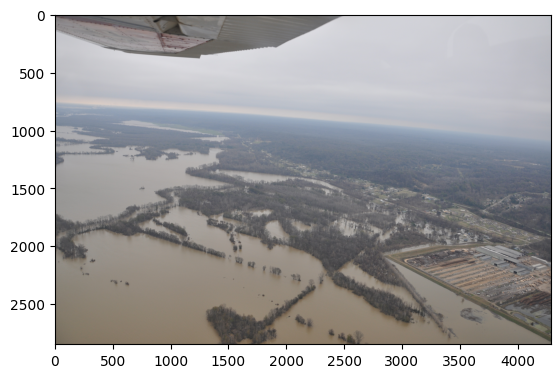

In [10]:
flood_image = ladi / "DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg"

with flood_image.open("rb") as f:
    i = Image.open(f)
    plt.imshow(i)

In [11]:
# Now just this one image file is in the cache
!tree {ladi.fspath}

data/ladi/Images/FEMA_CAP/2020/70349
└── DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg

0 directories, 1 file


In [12]:
# let's explicitly cleanup this directory, since it is not handled for us
!rm -rf data

## Accessing the cached version directly (read-only)

Many Python libraries don't properly handle `PathLike` objects. These libraries often only expect a `str` to be passed when working with files or, even worse, they will call `str(p)` on a Path that is passed before using it.

To use `cloudpathlib` with these libraries, you can pass `.fspath` which will provide the path to the cached version of the file as a string. 

**Warning:** Using the `.fspath` property will download the file from the cloud if it does not exist yet in the cache.

**Warning:** Since we are no longer in control of opening/closing the file, we cannot upload any changes when the file is closed. Therefore, you should treat any code where you use `fspath` as _read only_. Writes directly to `fspath` will not be uploaded to the cloud.


## Handling conflicts

We try to be conservative in terms of not losing data—especially data stored on the cloud, which is likely to be the canonical version. Given this, we will raise exceptions in two scenarios:

`OverwriteNewerLocalError`
This exception is raised if we are asked to download a file, but our local version in the cache is newer. This likely means that the cached version has been updated, but not pushed to the cloud. To work around this you could remove the cache version explicitly if you _know_ you don't need that data. If you did write changes you need, make sure your code uses the `cloudpathlib` versions of the `open`, `write_text`, or `write_bytes` methods, which will upload your changes to the cloud automatically.

The `CloudPath.open` method supports a `force_overwrite_from_cloud` kwarg to force overwriting your local version.

`OverwriteNewerCloudError`
This exception is raised if we are asked to upload a file, but the one on the cloud is newer than our local version. This likely means that a separate process has updated the cloud version, and we don't want to overwrite and lose that new data in the cloud.

The `CloudPath.open` method supports a `force_overwrite_to_cloud` kwarg to force overwriting the cloud version.



## Clearing the file cache

There's no perfect strategy for when to clear the file cache, and different applications will have different requirements and preferences. `cloudpathlib` provides fine-grained control over when cloud files are removed from the local disk. The cache can be emptied both manually and automatically. Because `cloudpathlib` uploads any changed files opened with `CloudPath.open` to the cloud as soon as they are closed, it is safe to delete the cached version of the file at any point as long as the file is not opened for writing at the time you are trying to remove it. If necessary, the file will be re-downloaded next time it is needed.

We provide a number of ways to clear the file cache that can be useful if you want to reclaim disk space or if you don't need to keep cached files around.



### Manually

It is recommended you pick an automatic strategy that works for your application. However, if you need to, you can clear the cache manually in three different ways: for individual CloudPath files, at the level of a `Client` instance, or at the operating system level. 

 - `CloudPath.clear_cache()` - for an individual `CloudPath` remove the cached version of the file if it exists.
 - `*Client.clear_cache()` - All files downloaded by this specific client instance will be removed from the cache. If you didn't create a client instance yourself, you can get the one that is used by a cloudpath with `CloudPath.client` or get the default one for a particular provider with `get_default_client`, for example by calling `S3Client.get_default_client().clear_cache()`.
 - By deleting the cached file itself or the containing directory using any normal method. To see where on a disk the cache is, you can use `CloudPath.fspath` for an individual file or use `*Client._local_cache_dir` for the client's cache. You can then use any method you like to delete these local files.

However, for most cases, you shouldn't need to manage the file cache manually. By setting the automatic cache clearing beahvior to the most appropriate one for your use case below, you can have the cache automatically cleared.



### Automatically

We provide a number of different ways for the cache to get cleared automatically for you depending on your use case. These range from no cache clearing done by `cloudpathlib` (`"persistent"`), to the most aggressive (`"close_file"`), which deletes a file from the cache as soon as the file handle is closed and the file is uploaded to the cloud, if it was changed).

The modes are defined in the `FileCacheMode` enum, which you can use directly or you can use the corresponding string value. Examples of both methods are included below.

Note: There is not currently a cache mode that _never_ writes a file to disk and only keeps it in memory.

 - `"persistent"` - `cloudpathlib` does not clear the cache at all. In this case, you must also pass a `local_cache_dir` when you instantiate the client.
 - `"tmp_dir"` (_default_) - Cached files are saved using Python's [`TemporaryDirectory`](https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory). This provides three potential avenues for the cache to get cleared. First, cached files are removed by `cloudpathlib` when the `*Client` object is garbage collected. This happens on the next garbage collection run after the object leaves scope or `del` is called. Second, Python clears a temporary directory if all references to that directory leave scope. Finally since the folder is in an operating system temp directory, it will be cleared by the OS (which, depending on the OS, may not happen until system restart).
 - `"cloudpath_object"` - cached files are removed when the `CloudPath` object is garbage collected. This happens on the next garbage collection run after the object leaves scope or `del` is called.
 - `"close_file"` - since we only download a file to the cache on read/write, we can ensure the cache is empty by removing the cached file as soon as the read/write is finished. Reading/writing the same `CloudPath` multiple times will result in re-downloading the file from the cloud. Note: For this to work, `cloudpath` needs to be in control of the reading/writing of files. This means your code base should use the `CloudPath.write_*`, `CloudPath.read_*`, and `CloudPath.open` methods. Using `CloudPath.fspath` (or passing the `CloudPath` as a `PathLike` object to another library) will not clear the cache on file close since it was not opened by `cloudpathlib`.

Note: Although we use it in the examples below, for `"cloudpath_object"` and `"tmp_dir"` you normally shouldn't need to explicitly call `del`. Letting Python garbage collection run on its own once all references to the object leave scope should be sufficient. See details [in the Python docs](https://docs.python.org/3/reference/datamodel.html?highlight=__del__#object.__del__)).



### Setting the cache clearing method

You can set the cache clearing method either through the environment variable `CLOUPATHLIB_FILE_CACHE_MODE` or by passing the mode to the `*Client` when you instantiate it. See below for an example.

You can set `CLOUPATHLIB_FILE_CACHE_MODE` to any of the supported values, which are printed below.

In [13]:
from cloudpathlib.enums import FileCacheMode

print("\n".join(FileCacheMode))

persistent
tmp_dir
cloudpath_object
close_file


### File cache mode: `"close_file"`

Example instantiation by passing a string to the client.

Local cache file is gone as soon as file is closed for reading.

In [14]:
# pass as string to client instantiation
no_cache_client = S3Client(file_cache_mode="close_file")

flood_image = no_cache_client.CloudPath(
    "s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg"
)

with flood_image.open("rb") as f:
    i = Image.open(f)
    print("Image loaded...")

# Illustrate that even though we read the file, the cache version does not exist
print("Cache file exists after finished reading: ", flood_image._local.exists())

Image loaded...
Cache file exists after finished reading:  False


### File cache mode: `"cloudpath_object"`

Example instantiation by passing enum member to the client.

Local cache file exists after file is closed for reading.

Local cache file is gone after `CloudPath` is no longer referenced (done explicitly with `del` here, but is usually called automatically by the garbage collector. See details [in the Python docs](https://docs.python.org/3/reference/datamodel.html?highlight=__del__#object.__del__)).

In [15]:
# pass enum to client instantiation
cloud_path_client = S3Client(file_cache_mode=FileCacheMode.cloudpath_object)

flood_image = cloud_path_client.CloudPath(
    "s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg"
)

with flood_image.open("rb") as f:
    i = Image.open(f)
    print("Image loaded...")


# cache exists while the CloudPath object persists
local_cached_file = flood_image._local
print("Cache file exists after finished reading: ", local_cached_file.exists())

# decrement reference count so garbage collector cleans up the file
del flood_image

# file is now cleaned up
print("Cache file exists after CloudPath is no longer referenced: ", local_cached_file.exists())

Image loaded...
Cache file exists after finished reading:  True
Cache file exists after CloudPath is no longer referenced:  False


### File cache mode: `"tmp_dir"` (default)

Local cache file exists after file is closed for reading.

Local cache file exists after `CloudPath` is no longer referenced.

Local cache file is gone after the `Client` object is no longer referenced (done explicitly with `del` here, but is usually called automatically by the garbage collector. See details [in the Python docs](https://docs.python.org/3/reference/datamodel.html?highlight=__del__#object.__del__)).

In [16]:
tmp_dir_client = S3Client()

flood_image = tmp_dir_client.CloudPath(
    "s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg"
)

with flood_image.open("rb") as f:
    i = Image.open(f)
    print("Image loaded...")

# cache exists while the CloudPath object persists
local_cached_file = flood_image._local
print("Cache file exists after finished reading: ", local_cached_file.exists())

# decrement reference count so garbage collection runs
del flood_image

# file still exists
print("Cache file exists after CloudPath is no longer referenced: ", local_cached_file.exists())

# decrement reference count so garbage collector removes the client
del tmp_dir_client

# file still exists
print("Cache file exists after Client is no longer referenced: ", local_cached_file.exists())

Image loaded...
Cache file exists after finished reading:  True
Cache file exists after CloudPath is no longer referenced:  True
Cache file exists after Client is no longer referenced:  False


### File cache mode: `"persistent"`

If `local_cache_dir` is specificed, but `file_cache_mode` is not, then the mode is set to `"persistent"` automatically. Conversely, if you set the mode to `"persistent"` explicitly, you must also pass `local_cache_dir` or the `Client` will raise `InvalidConfigurationException`.

Local cache file exists after file is closed for reading.

Local cache file exists after `CloudPath` is no longer referenced.

Local cache exists after the `Client` object is no longer referenced.

In [17]:
persistent_client = S3Client(local_cache_dir="./cache")

# cache mode set automatically to persistent if local_cache_dir and not explicit
print("Client cache mode set to: ", persistent_client.file_cache_mode)

# Just uses default client
flood_image = persistent_client.CloudPath(
    "s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg"
)

with flood_image.open("rb") as f:
    i = Image.open(f)
    print("Image loaded...")

# cache exists while the CloudPath object persists
local_cached_file = flood_image._local
print("Cache file exists after finished reading: ", local_cached_file.exists())

# decrement reference count so garbage collection runs
del flood_image

# file still exists
print("Cache file exists after CloudPath is no longer referenced: ", local_cached_file.exists())

# decrement reference count so garbage collector removes the client
client_cache_dir = persistent_client._local_cache_dir
del persistent_client

# file still exists
print("Cache file exists after Client is no longer referenced: ", local_cached_file.exists())


# explicitly remove persistent cache file
import shutil

shutil.rmtree(client_cache_dir)

Client cache mode set to:  FileCacheMode.persistent
Image loaded...
Cache file exists after finished reading:  True
Cache file exists after CloudPath is no longer referenced:  True
Cache file exists after Client is no longer referenced:  True


We show an example below of `InvalidConfigurationException` being raised with the mode being interpreted from the environment variable.

In [18]:
import os

# set the mode here so that it will be used when we instantiate the client
os.environ["CLOUPATHLIB_FILE_CACHE_MODE"] = "persistent"

tmp_dir_client = S3Client()

InvalidConfigurationException: If you use the 'FileCacheMode.persistent' cache mode, you must pass a `local_cache_dir` when you instantiate the client.

### Caveats

 - Automatic cache clearing works in most contexts, but there can be cases where execution of a program is halted before `cloudpathlib`'s cache clearing code is able to run. It is a good practice to monitor your cache folders and, if using temporary directories, trigger your operating system's temp directory clean up (which is OS-dependent, but restarting is usually sufficient).

 - Using `with CloudPath.open()` as a context manager to open files for read or write is the best way to ensure that automatic cache clearing happens consistently. The `"close_file"` cache clearing mode will not work as expected if you use another method to open files (e.g., calling the Python built-in `open`, using `CloudPath.fspath`, or where another library handles the opening/closing of the file).

 - The `download_to` and `upload_from` methods do not cache the file, since we assume if you are downloading or uploading you explicitly want the file to be in a particular location or know where it is already.